In [1]:
"""
#mounting my Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive'
"""

"\n#mounting my Google Drive with Google Colab\nfrom google.colab import drive\ndrive.mount('/content/drive')\n%cd '/content/drive/My Drive'\n"

In [2]:
!pwd

/home/melkor/projects/anam_code_folder


In [1]:
!pip install -r requirements.txt
!pip install seaborn
!pip install albumentations
!pip install patchify


In [2]:

import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import patchify
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album


In [3]:
!pip freeze>requirements1.txt

In [3]:

!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [5]:
# importing all the datapaths and converying the images into the list

DATA_DIR = 'Dataset_1000'

x_train_dir = os.path.join(DATA_DIR , 'images')
y_train_dir = os.path.join(DATA_DIR , 'masks')

x_valid_dir = os.path.join(DATA_DIR, 'rgb252')
y_valid_dir = os.path.join(DATA_DIR, 'mask252')
x_test_dir = os.path.join(DATA_DIR , 'test50_rgb')
y_test_dir = os.path.join(DATA_DIR , 'test50_mask')

print(len(os.listdir(x_train_dir)))
print(len(os.listdir(y_train_dir)))
print(len(os.listdir(x_valid_dir)))
print(len(os.listdir(y_valid_dir)))
print(len(os.listdir(x_test_dir)))
print(len(os.listdir(y_test_dir)))

1008
1008
252
252
60
60


In [6]:

#All dataset classes and their corresponding RGB values in labels
class_dict = pd.read_csv("label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road', 'lanemarks', 'curb', 'person', 'rider', 'vehicles', 'bicycle', 'motorcycle', 'traffic sign']
Class RGB values:  [[0, 0, 0], [149, 213, 0], [216, 45, 128], [0, 140, 88], [255, 0, 0], [255, 255, 255], [0, 0, 255], [0, 255, 255], [30, 170, 250], [0, 128, 128]]


In [7]:
#Shortlist specific classes to segment
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road', 'lanemarks', 'curb', 'person', 'rider', 'vehicles', 'bicycle', 'motorcycle', 'traffic sign']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Selected Names: ', select_classes)
print('Selected Class RGB values: ', select_class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Selected Names:  ['background', 'road', 'lanemarks', 'curb', 'person', 'rider', 'vehicles', 'bicycle', 'motorcycle', 'traffic sign']
Selected Class RGB values:  [[  0   0   0]
 [149 213   0]
 [216  45 128]
 [  0 140  88]
 [255   0   0]
 [255 255 255]
 [  0   0 255]
 [  0 255 255]
 [ 30 170 250]
 [  0 128 128]]


In [8]:
#Helper functions for viz. & one-hot encoding/decoding
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [51]:
# def adjust_gamma(img, gamma=1.0):
#     # Check for 3 channels 
#     assert img.shape[0] == 3, "Image should have 3 channels"

#     img = img.transpose((2, 0, 1))  # Transpose from (3, w, h) to (c, h, w)

#     # Directly process a 3D image with channels first
#     invGamma = 1.0 / gamma
#     table = np.array([((i / 255.0) ** invGamma) * 255 
#                       for i in np.arange(0, 256)]).astype("uint8")

#     # Apply gamma correction (looping since cv2.LUT expects channels-first format)
#     for c in range(3):
#         img[c] = cv2.LUT(np.array(img[c], dtype=np.uint8), table)

#     return img.transpose((1, 2, 0)) # Transpose back to (3, w, h)


# # def clahe_equalized(imgs):
# #     # Assert len(imgs.shape) == 4  # 4D arrays
# #     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
# #     imgs_equalized = np.empty(imgs.shape)
# #     for i in range(imgs.shape[0]):
# #         for c in range(3):  # Apply separately to each channel
# #             imgs_equalized[i, c] = clahe.apply(np.array(imgs[i, c], dtype=np.uint8))
# #     return imgs_equalized
# def clahe_equalized(img):
#     # Check for 3 channels (RGB images)
#     assert img.shape[0] == 3, "Image should be RGB format"

#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     img = img.transpose((2, 0, 1))  # Transpose from (3, w, h) to (c, h, w)

#     # Split channels, apply CLAHE, and merge back
#     b, g, r = cv2.split(img)
#     b_eq = clahe.apply(b)
#     g_eq = clahe.apply(g)
#     r_eq = clahe.apply(r)

#     img_equalized = cv2.merge((b_eq, g_eq, r_eq))

#     # Transpose back to original format
#     return img_equalized.transpose((1, 2, 0))  #  Transpose from (c, h, w) to (3, w, h)




# # def histo_equalized(imgs):
# #     # Assert len(imgs.shape) == 4  # 4D arrays
# #     # Assert imgs.shape[1] == 3    # RGB channels
# #     imgs_equalized = np.empty(imgs.shape)
# #     for i in range(imgs.shape[0]):
# #         for c in range(3):  # Apply separately to each channel
# #             imgs_equalized[i, c] = cv2.equalizeHist(np.array(imgs[i, c], dtype=np.uint8))
# #     return imgs_equalized
# def histo_equalized(img):
#     # Check for 3 channels (RGB images)
#     assert img.shape[0] == 3, "Image should be RGB format"

#     img = img.transpose((2, 0, 1))  # Transpose from (3, w, h) to (c, h, w)

#     # Split channels, apply histogram equalization, and merge back
#     b, g, r = cv2.split(img)
#     b_eq = cv2.equalizeHist(b)
#     g_eq = cv2.equalizeHist(g)
#     r_eq = cv2.equalizeHist(r)

#     img_equalized = cv2.merge((b_eq, g_eq, r_eq))

#     # Transpose back to original format
#     return img_equalized.transpose((1, 2, 0))  #  Transpose from (c, h, w) to (3, w, h)
def adjust_gamma(img, gamma=1.0):
    # Check for 3 channels 
    assert img.shape[2] == 3, "Image should have 3 channels"

    # Directly process a 3D image with channels last
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 
                      for i in np.arange(0, 256)]).astype("uint8")

    # Apply gamma correction (looping since cv2.LUT expects channels-first format)
    for c in range(3):
        img[:, :, c] = cv2.LUT(np.array(img[:, :, c], dtype=np.uint8), table)

    return img 

def clahe_equalized(img):
    #  Check for 3 channels (RGB images)
    assert img.shape[2] == 3, "Image should be RGB format"

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Split channels, apply CLAHE, and merge back
    b, g, r = cv2.split(img)
    b_eq = clahe.apply(b)
    g_eq = clahe.apply(g)
    r_eq = clahe.apply(r)

    return cv2.merge((b_eq, g_eq, r_eq))

def histo_equalized(img):
    #  Check for 3 channels (RGB images)
    assert img.shape[2] == 3, "Image should be RGB format"

    # Split channels, apply histogram equalization, and merge back
    b, g, r = cv2.split(img)
    b_eq = cv2.equalizeHist(b)
    g_eq = cv2.equalizeHist(g)
    r_eq = cv2.equalizeHist(r)

    return cv2.merge((b_eq, g_eq, r_eq))

def dataset_normalized(imgs):
    # Assert len(imgs.shape) == 4  # Ensure the data is 4D: batch_size x channels x height x width
    # Assert imgs.shape[1] == 3    # Check for 3 channels (RGB)

    imgs_normalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):  # Iterate over each image
        for c in range(3):  # Normalize each channel independently
            channel = imgs[i, c, :, :]
            channel_std = np.std(channel)
            channel_mean = np.mean(channel)
            imgs_normalized[i, c, :, :] = (channel - channel_mean) / channel_std
            # Scaling the channel to 0-255 range
            imgs_normalized[i, c, :, :] = ((imgs_normalized[i, c, :, :] - np.min(imgs_normalized[i, c, :, :])) / 
                                           (np.max(imgs_normalized[i, c, :, :]) - np.min(imgs_normalized[i, c, :, :]))) * 255
    return imgs_normalized


def my_PreProc(data):
    print('Preprocessing the data...', data.shape)

    # Add batch dimension 
    data = np.expand_dims(data, axis=0) 

    # Normalize the dataset
    normalized_data = dataset_normalized(data)

    # Apply CLAHE (adjust the function to work with RGB)
    clahe_data = clahe_equalized(normalized_data)

    # Apply Gamma Correction (adjust the function to work with RGB)
    gamma_corrected_data = adjust_gamma(clahe_data, 1.2)

    # Scale to 0-1 range
    final_data = gamma_corrected_data / 255. 

    # Remove the extra batch dimension at the end
    return final_data[0]  



In [9]:
from torch.utils.data import Dataset
class WoodscapeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, class_rgb_values, patch_size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_fns = sorted(os.listdir(image_dir))[:1000]
        self.mask_fns = sorted(os.listdir(mask_dir))[:1000]
        self.class_rgb_values = class_rgb_values
        self.patch_size = patch_size
        self.image_dataset, self.mask_dataset = self.generate_patches()

    def generate_patches(self):
        image_dataset = []
        mask_dataset = []
        visualize_first_image = True

        for idx, (image_fn, mask_fn) in enumerate(zip(self.image_fns, self.mask_fns)):
            image_fp = os.path.join(self.image_dir, image_fn)
            mask_fp = os.path.join(self.mask_dir, mask_fn)

            image = cv2.imread(image_fp, cv2.IMREAD_COLOR)
            mask = cv2.imread(mask_fp, cv2.IMREAD_COLOR)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            SIZE_X = (image.shape[1] // self.patch_size) * self.patch_size
            SIZE_Y = (image.shape[0] // self.patch_size) * self.patch_size

            image = Image.fromarray(image).crop((0, 0, SIZE_X, SIZE_Y))
            mask = Image.fromarray(mask).crop((0, 0, SIZE_X, SIZE_Y))

            patches_img = patchify.patchify(np.array(image), (self.patch_size, self.patch_size, 3), step=self.patch_size)
            patches_mask = patchify.patchify(np.array(mask), (self.patch_size, self.patch_size, 3), step=self.patch_size)

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i, j, 0]
                    single_patch_mask = patches_mask[i, j, 0]
                    # Ensure the mask has the correct dimensionality (HWC)
                    single_patch_mask = single_patch_mask[:, :, :3]
                    if np.any(single_patch_mask):
                        image_dataset.append(single_patch_img)
                        mask_dataset.append(single_patch_mask)

        return np.array(image_dataset), np.array(mask_dataset)

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, index):
        single_patch_img = self.image_dataset[index].astype(np.float32) #/ 255.0

        mean = (0.485, 0.456, 0.406)  # Replace with your calculated mean 
        std = (0.229, 0.224, 0.225)  # Replace with your calculated std
        single_patch_img = (single_patch_img / 255.0 - mean) / std 
        single_patch_mask = one_hot_encode(self.mask_dataset[index], self.class_rgb_values)
        # single_patch_img =  single_patch_img/ 255 #my_PreProc(single_patch_img)
        # print(single_patch_img.shape)
        image_tensor = torch.from_numpy(single_patch_img).permute(2, 0, 1)
        mask_tensor = torch.from_numpy(single_patch_mask).permute(2, 0, 1)
        #mask_tensor = torch.Tensor(mask_tensor).float()

        return image_tensor, mask_tensor
    




class WoodscapeDatasetTest(Dataset):
    def __init__(self, image_dir, mask_dir, class_rgb_values, patch_size=256):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_fns = sorted(os.listdir(image_dir)[0:1000])
        self.mask_fns = sorted(os.listdir(mask_dir)[0:1000])
        self.class_rgb_values = class_rgb_values

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, index):
        # Load the image and mask
        image_fp = os.path.join(self.image_dir, self.image_fns[index])
        mask_fp = os.path.join(self.mask_dir, self.mask_fns[index])

        image = cv2.imread(image_fp, 1)
        mask = cv2.imread(mask_fp, 1)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Normalize and transform
        image = image.astype(np.float32) / 255.0
        mask_one_hot = one_hot_encode(mask, self.class_rgb_values)

        # Convert to PyTorch tensors
        image_tensor = torch.tensor(image).permute(2, 0, 1)  # Channels first
        mask_tensor = torch.tensor(mask_one_hot).permute(2, 0, 1)

        return image_tensor, mask_tensor


In [10]:
from PIL import Image
#Feed the train images and masks to the woodscapeDataset function
dataset = WoodscapeDatasetTest(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values , patch_size=256) # train on orginal 
#dataset = WoodscapeDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values , patch_size=256) # train on patches




length of dataset: 1000
shape of image: (966, 1280, 3)
shape of mask: (966, 1280, 10)
shape of image: (966, 1280, 3)
shape of mask: (966, 1280, 10)


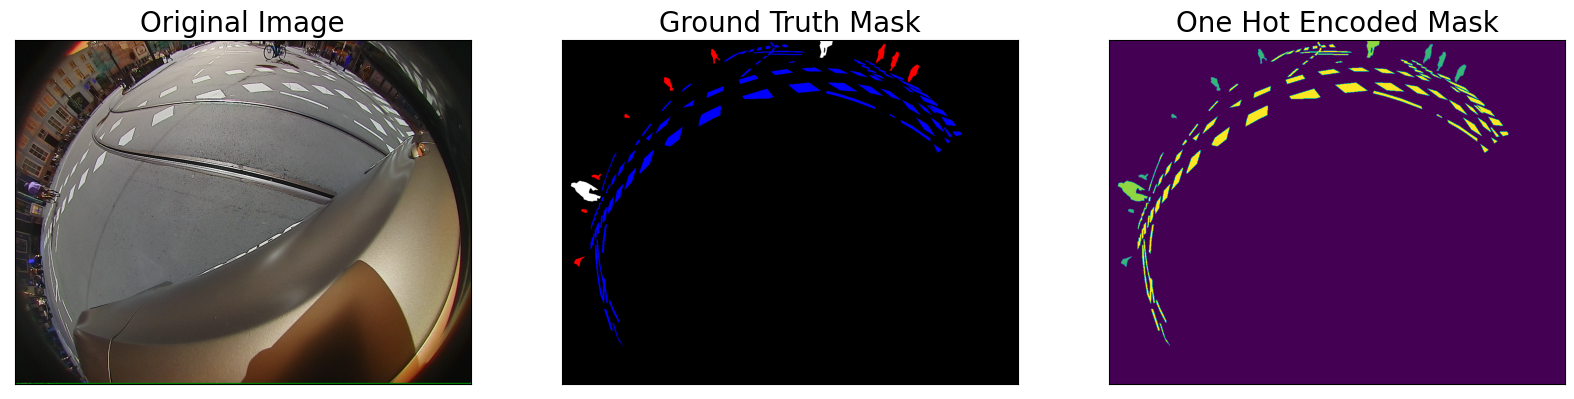

In [11]:
print(f"length of dataset:", len(dataset))
random_idx = random.randint(0, len(dataset) - 1)
woodscape , label_class= dataset[random_idx]
# Convert PyTorch tensor to NumPy array
  # Convert to (Height, Width, Channels)
# woodscape = woodscape.permute(1, 2, 0).numpy()
# label_class= label_class.permute(1, 2, 0).numpy()    # Convert to (Height, Width, Channels)
image=woodscape
mask=label_class

image = image.permute(1, 2, 0).numpy()  # Convert to (Height, Width, Channels)
mask = mask.permute(1, 2, 0).numpy()    # Convert to (Height, Width, Channels)

#print shape of image and mask
print(f"shape of image:",image.shape)
print(f"shape of mask:",mask.shape)

print(f"shape of image:",image.shape)

print(f"shape of mask:",mask.shape)


visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [12]:
#implementation of Deformaable UNET Network from Scratch for understanding 
import torchvision


# def crop_and_concat(upsampled, bypass, crop=False):
#     if crop:
#         c = (bypass.size()[2] - upsampled.size()[2]) // 2
#         bypass = bypass[:, :, c:bypass.size()[2]-c, c:bypass.size()[3]-c]
#     return torch.cat((upsampled, bypass), 1)
def crop_and_concat(upsampled, bypass, crop = False):
    diffY = bypass.size()[2] - upsampled.size()[2]
    diffX = bypass.size()[3] - upsampled.size()[3]

    bypass = bypass[:, :, diffY // 2: bypass.size()[2] - diffY // 2 - diffY % 2,
                    diffX // 2: bypass.size()[3] - diffX // 2 - diffX % 2]

    return torch.cat((upsampled, bypass), 1)



class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False):
        super(DeformableConv2d, self).__init__()

        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        self.dilation = dilation

        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     dilation=self.dilation,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels,
                                        1 * kernel_size[0] * kernel_size[1],
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=self.padding,
                                        dilation=self.dilation,
                                        bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      dilation=self.dilation,
                                      bias=bias)

    def forward(self, x):
        # h, w = x.shape[2:]
        # max_offset = max(h, w)/4.

        offset = self.offset_conv(x)  # .clamp(-max_offset, max_offset)
                # Print offset values for the first training sample only
        # print("Offset values for the first training sample:", offset[0])
        # print("Offset shape:", offset.shape)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        # op = (n - (k * d - 1) + 2p / s)
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          dilation=self.dilation)

        return x


class DUNet(nn.Module):

    def __init__(self, num_classes):
        super(DUNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = DeformableConv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                                kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256,
                                                kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                                kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                                kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = DeformableConv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        # print(X.shape,"Here we are printing the shape of input to the first conv blcok, contracting_11")
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        # middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]

        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(crop_and_concat(expansive_11_out, contracting_41_out)) # Cropping for matching dimensions
        # expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        # expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(crop_and_concat(expansive_21_out, contracting_31_out))
        # expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(crop_and_concat(expansive_31_out, contracting_21_out))

        # expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(crop_and_concat(expansive_41_out, contracting_11_out))
        # expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        # print("output_out shape: the final outout from the model which is used in the loss fx",output_out.shape)
        return output_out


In [13]:
CLASSES = class_names
model = DUNet(num_classes=len(CLASSES))

In [14]:
# Get train and val dataset instances
train_dataset = WoodscapeDataset(
    x_train_dir, y_train_dir,
    class_rgb_values=select_class_rgb_values,
    patch_size=256
)

valid_dataset = WoodscapeDataset(
    x_valid_dir, y_valid_dir,
    class_rgb_values=select_class_rgb_values,
    patch_size=256
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=0)

In [19]:
!pip install segmentation_models_pytorch

In [15]:
import segmentation_models_pytorch.utils as smp_utils
import segmentation_models_pytorch as smp
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 20

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp_utils.losses.DiceLoss()
#loss = nn.CrossEntropyLoss()

# define metrics-*
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

model = DUNet(num_classes = len(CLASSES)).to(DEVICE)
# model = smp.DeepLabV3(
#     encoder_name="resnet34", 
#     encoder_weights="imagenet",  
#     classes=len(CLASSES), 
#     activation=None  # You can choose an activation function (e.g., 'softmax', 'sigmoid', etc.)
# ).to(DEVICE)

# print(len(CLASSES))

In [16]:
import torch

# Assuming 'train_loader' and 'valid_loader' are your data loaders for training and validation
# 'model', 'loss', 'metrics', 'optimizer', 'DEVICE' are already defined

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_iou = 0

    for images, one_hot_masks in train_loader:
        images = images.to(DEVICE).float()
        one_hot_masks = one_hot_masks.to(DEVICE)
        # print("mask one hot shape",one_hot_masks.shape)
        masks = torch.argmax(one_hot_masks.type(torch.float32), dim=1)
        # print("mask not one hot shape",masks.shape)

        optimizer.zero_grad()
        outputs = model(images)
        # print("output shape",outputs.shape)
        loss_value = loss(outputs, one_hot_masks)
        train_loss += loss_value.item()
        # print("loss value",loss_value.item())
        train_iou += smp.utils.metrics.IoU()(outputs, one_hot_masks).item()
        
        loss_value.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)

    # Validation loop
    model.eval()
    valid_loss = 0
    valid_iou = 0

    with torch.no_grad():
        for images, one_hot_masks in valid_loader:
            images = images.to(DEVICE).float()
            one_hot_masks = one_hot_masks.to(DEVICE)
            masks = torch.argmax(one_hot_masks.type(torch.float32), dim=1)
            # masks = torch.argmax(one_hot_masks, dim=1)

            outputs = model(images)
            loss_value = loss(outputs, one_hot_masks)
            valid_loss += loss_value.item()
            valid_iou += smp.utils.metrics.IoU()(outputs, one_hot_masks).item()

    valid_loss /= len(valid_loader)
    valid_iou /= len(valid_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid IoU: {valid_iou:.4f}")


Epoch 1/20
Train Loss: 0.8934, Train IoU: 0.0583
Valid Loss: 2.4013, Valid IoU: 0.0570
Epoch 2/20
Train Loss: 0.8965, Train IoU: 0.0583
Valid Loss: -0.4368, Valid IoU: 0.0697
Epoch 3/20
Train Loss: 0.8981, Train IoU: 0.0581
Valid Loss: 1.3677, Valid IoU: 0.0574


KeyboardInterrupt: 

In [ ]:
torch.save(model, './DCUNET_best_model_1000.pth')

In [49]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
%%time
import torchvision
torch.cuda.empty_cache()


# Inside your training loop

# if TRAINING:

#     best_iou_score = 0.0
#     train_logs_list, valid_logs_list = [], []
         
#     for i in range(0, EPOCHS):
        
#         # Perform training & validation
#         print('\nEpoch: {}'.format(i))
#         train_logs = train_epoch.run(train_loader)
#         valid_logs = valid_epoch.run(valid_loader)
#         train_logs_list.append(train_logs)
#         valid_logs_list.append(valid_logs)
#         # Save model if a better val IoU score is obtained
#         if best_iou_score < valid_logs['iou_score']:
#             best_iou_score = valid_logs['iou_score']
#             torch.save(model, './DCUNET_best_model_1000.pth')
#             print('Model saved!')


In [21]:
# load best saved model checkpoint from the current run
if os.path.exists('./DCUNET_best_model_1000.pth'):
    best_model = torch.load('./DCUNET_best_model_1000.pth').to(DEVICE)
    print('Loaded Deformable model.')


Loaded Deformable model.


In [22]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [23]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class WoodscapeDatasetTest(Dataset):
    def __init__(self, image_dir, mask_dir, class_rgb_values):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_fns = sorted(os.listdir(image_dir)[0:10])
        self.mask_fns = sorted(os.listdir(mask_dir)[0:10])
        self.class_rgb_values = class_rgb_values

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, index):
        # Load the image and mask
        image_fp = os.path.join(self.image_dir, self.image_fns[index])
        mask_fp = os.path.join(self.mask_dir, self.mask_fns[index])

        image = cv2.imread(image_fp, 1)
        mask = cv2.imread(mask_fp, 1)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Normalize and transform
        image = image.astype(np.float32) / 255.0
        mask_one_hot = one_hot_encode(mask, self.class_rgb_values)

        # Convert to PyTorch tensors
        image_tensor = torch.tensor(image).permute(2, 0, 1)  # Channels first
        mask_tensor = torch.tensor(mask_one_hot).permute(2, 0, 1)

        return image_tensor, mask_tensor

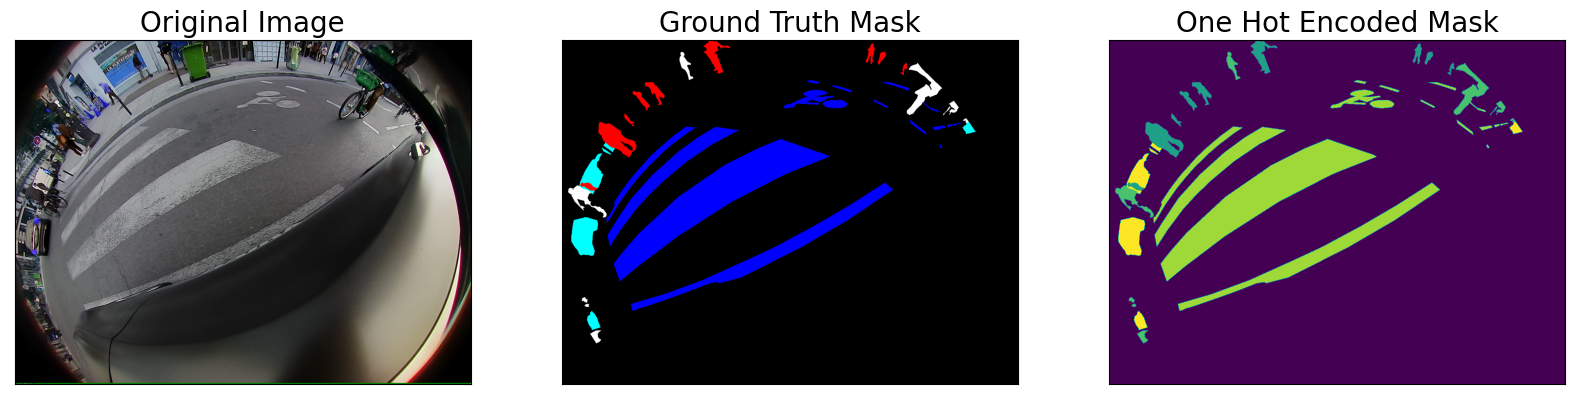

In [24]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = WoodscapeDataset(
    x_test_dir,
    y_test_dir,
    patch_size=256,
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = WoodscapeDatasetTest(
    x_test_dir, y_test_dir,

    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]
image = image.permute(1, 2, 0).numpy()  # Convert to (Height, Width, Channels)
mask = mask.permute(1, 2, 0).numpy()
visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [25]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

print shape of image: torch.Size([3, 256, 256])
print shape of gt_mask: torch.Size([10, 256, 256])
print shape of x_tensor: torch.Size([1, 3, 256, 256])
unique colors present in gt mask [0 1]
print shape of gt_mask: (256, 256, 3)
print shape of image_vis: (256, 256, 3)
torch.Size([1, 10, 256, 256])
shape of one_hot_predictions: torch.Size([256, 256, 10])
shape of one_hot_predictions: torch.Size([256, 256, 10])
shape of class_predictions: torch.Size([256, 256])
shape of pred_mask: (256, 256, 10)
Unique classes predicted: [0 1]
shape of pred_mask_colored: (256, 256, 3)


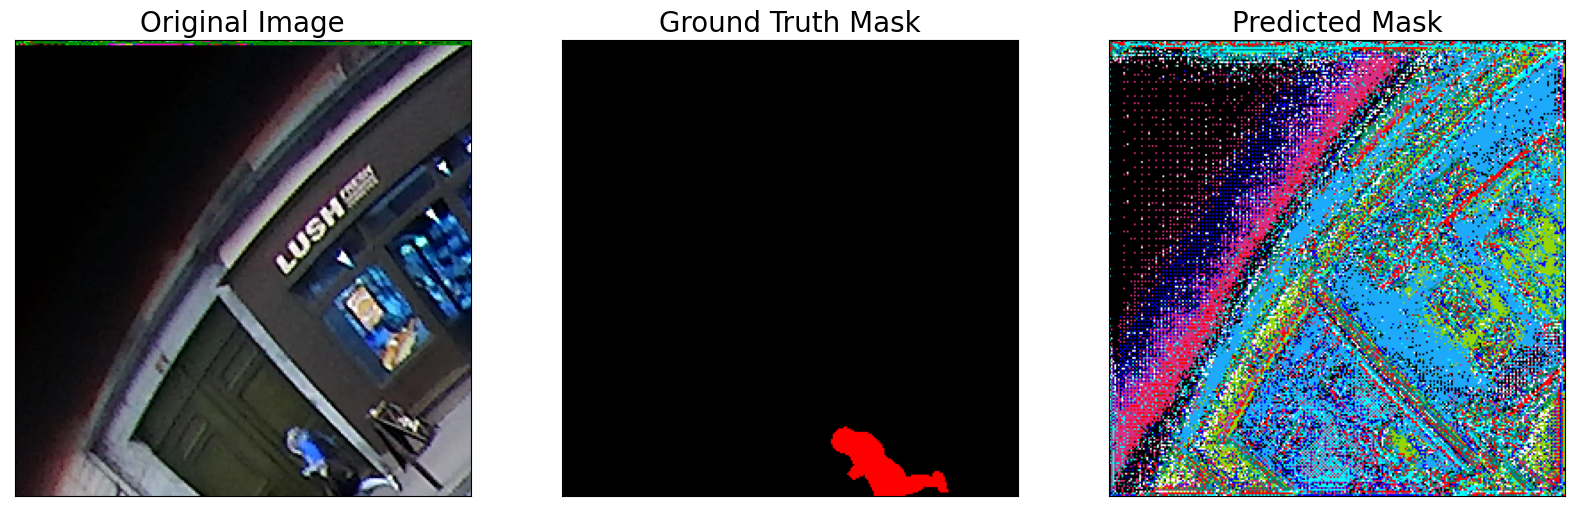

print shape of image: torch.Size([3, 256, 256])
print shape of gt_mask: torch.Size([10, 256, 256])
print shape of x_tensor: torch.Size([1, 3, 256, 256])
unique colors present in gt mask [0 1]
print shape of gt_mask: (256, 256, 3)
print shape of image_vis: (256, 256, 3)
torch.Size([1, 10, 256, 256])
shape of one_hot_predictions: torch.Size([256, 256, 10])
shape of one_hot_predictions: torch.Size([256, 256, 10])
shape of class_predictions: torch.Size([256, 256])
shape of pred_mask: (256, 256, 10)
Unique classes predicted: [0 1]
shape of pred_mask_colored: (256, 256, 3)


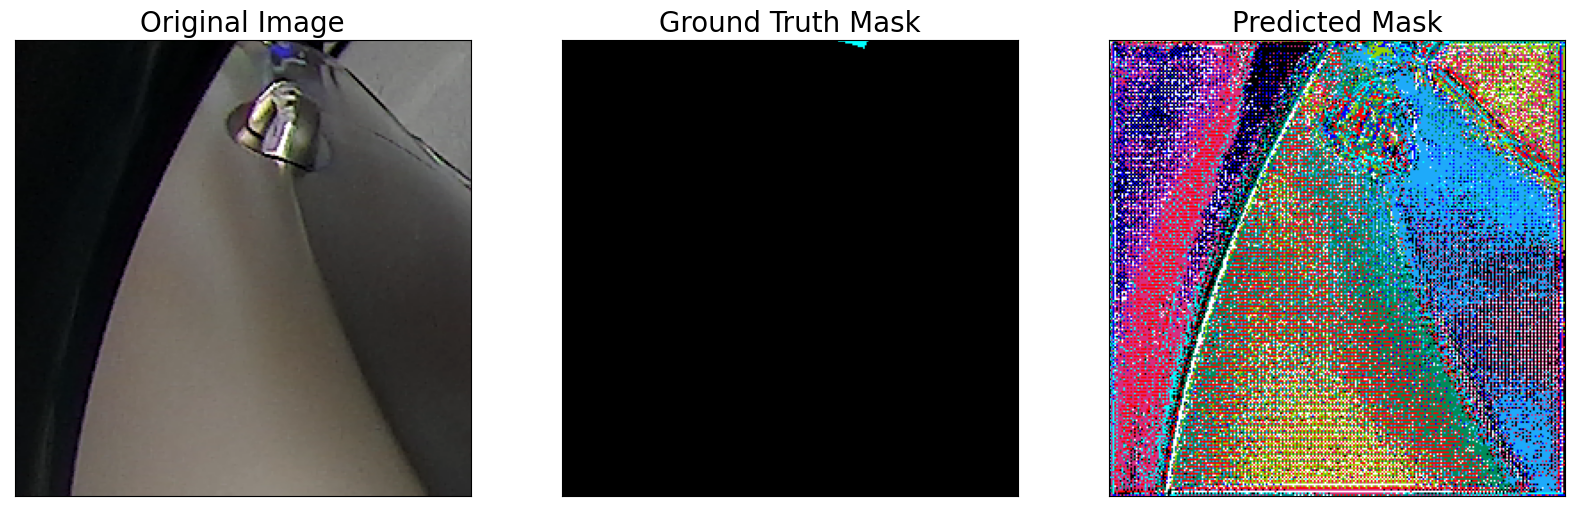

In [43]:
# for idx in range(len(test_dataset)):
for idx in range(2):
    idx = random.randint(0, len(test_dataset)-1)
    image, gt_mask = test_dataset[idx]
    print(f"print shape of image:", image.shape)
    print(f"print shape of gt_mask:", gt_mask.shape)

    # Convert PyTorch tensor to NumPy array
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Ensure the image has 3 channels (RGB)
    if image_np.shape[2] != 3:
        image_np = image_np[:, :, :3]

    x_tensor = torch.from_numpy(image_np).to(DEVICE).unsqueeze(0).permute(0, 3, 1, 2)
    print(f"print shape of x_tensor:", x_tensor.shape)
    gt_mask_np = gt_mask.permute(1, 2, 0).cpu().numpy()
    image_vis = image_np.astype('uint8')

    print("unique colors present in gt mask",np.unique(gt_mask_np).astype('uint8'))
    gt_mask_colored =colour_code_segmentation(reverse_one_hot(gt_mask_np), select_class_rgb_values)
    print(f"print shape of gt_mask:", gt_mask_colored.shape)
    print(f"print shape of image_vis:", image_vis.shape)

    # Move x_tensor to the same device as the model's weights (GPU)
    x_tensor = x_tensor.to(DEVICE)

    pred_mask = best_model(x_tensor)
    print(pred_mask.shape)

    # Get the class predictions
    class_predictions = torch.argmax(pred_mask, dim=1)
    class_predictions = class_predictions.squeeze()

    # One-hot encode the class predictions
    num_classes = 10
    one_hot_predictions = torch.nn.functional.one_hot(class_predictions, num_classes)

    # Reshape the one-hot predictions tensor
    one_hot_predictions = one_hot_predictions.permute(2, 0, 1)  # Reshape to [num_classes, 256, 256]
    one_hot_predictions = one_hot_predictions.permute(1, 2, 0)
    print("shape of one_hot_predictions:", one_hot_predictions.shape)

    # Convert one_hot_predictions to NumPy array if needed
    one_hot_predictions_np = one_hot_predictions.detach().cpu().numpy()

    print("shape of one_hot_predictions:", one_hot_predictions.shape)
    # pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    print(f"shape of class_predictions:", class_predictions.shape)
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = one_hot_predictions_np#np.transpose(pred_mask, (1, 2, 0))
    print(f"shape of pred_mask:", pred_mask.shape)
    # Assuming select_classes is a list of class names
    unique_classes_predicted = np.unique(pred_mask).astype('uint8')

    print("Unique classes predicted:", unique_classes_predicted)

    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    print(f"shape of pred_mask_colored:",pred_mask.shape)
    # Choose the channel to visualize (e.g., 'rider')
    #pred_rider_heatmap = pred_mask[:, :, select_classes.index('rider')]

    # Visualize the predicted rider heatmap and the ground truth mask
    #pred_rider_heatmap = pred_rider_heatmap.astype('uint8')
    #print(f"shape of pred_rider_heatmap:", pred_rider_heatmap)

    # Ensure that the visualization function accepts uint8 images
    visualize(
        original_image = image_np,
        ground_truth_mask = gt_mask_colored,
        predicted_mask = pred_mask,

    )

In [44]:
#Model Evaluation on Test data
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid:   0%|          | 0/900 [00:00<?, ?it/s]

valid: 100%|██████████| 900/900 [00:28<00:00, 31.81it/s, dice_loss - 0.9806, iou_score - 0.02444] 
Evaluation on Test Data: 
Mean IoU Score: 0.0244
Mean Dice Loss: 0.9806


In [28]:

#Plot Dice Loss & IoU Metric for Train vs. Val
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dice_loss,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166,1.100166
iou_score,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798,0.042798


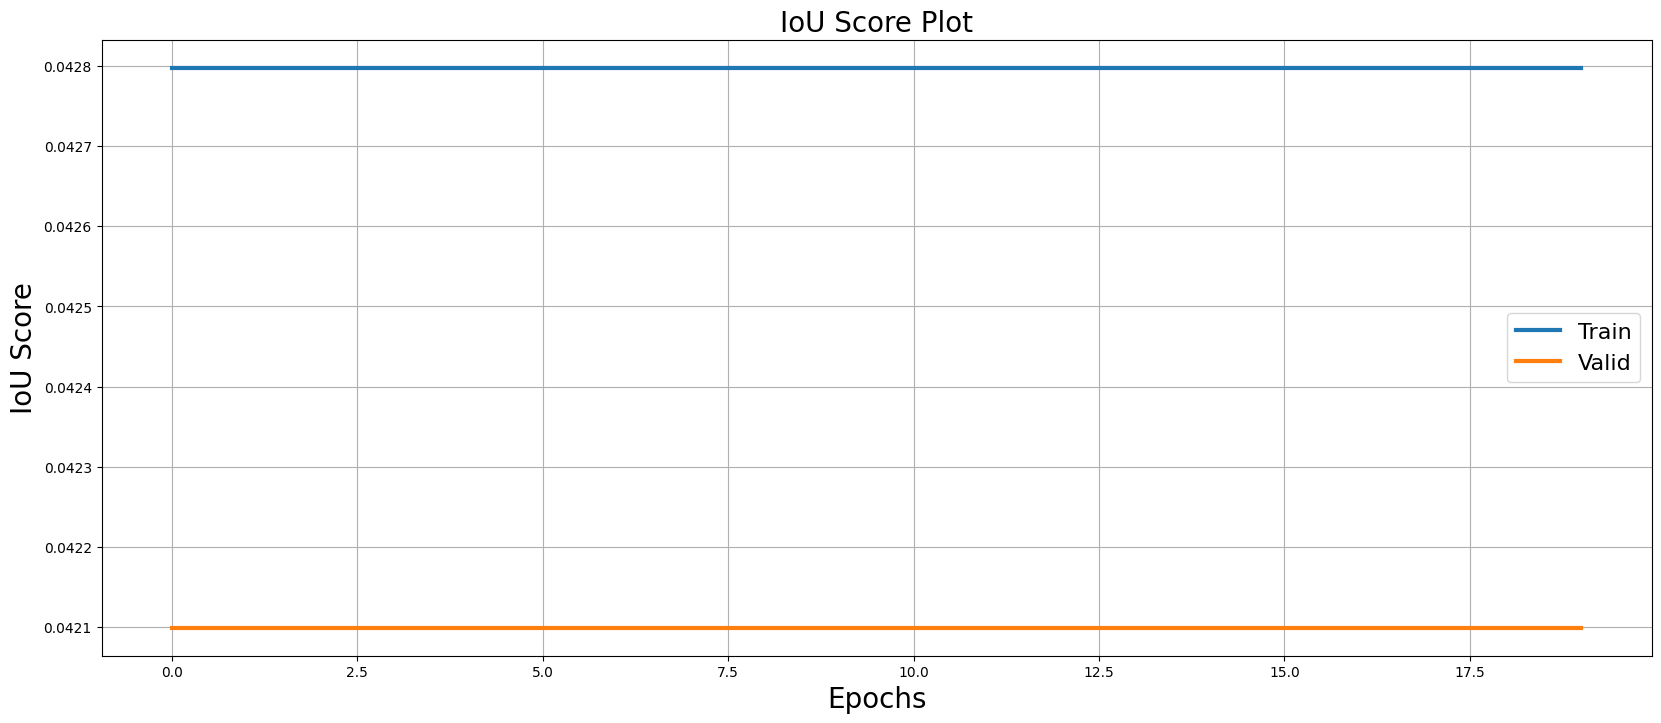

In [29]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()


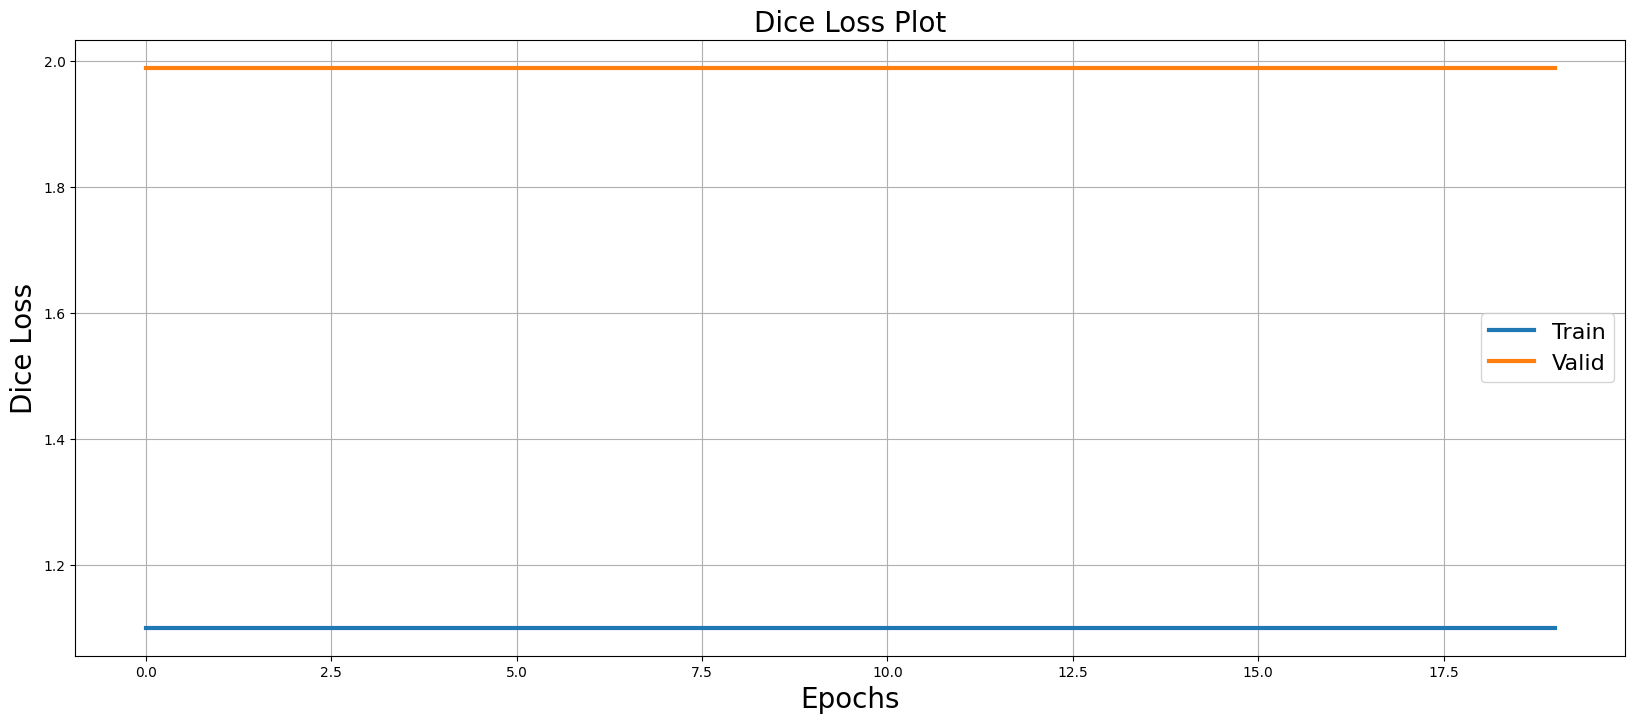

In [30]:

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()
